In [ ]:
# MexCulture142_Altered/
# ├── images/
# │   ├── Colonial_AcademiaDeBellasArtes_Queretaro_N_1.png
# │   ├── Colonial_AcademiaDeBellasArtes_Queretaro_N_2.png
# │   └── Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_N_1.png
# │
# ├── gazefixationsdensitymaps/
# │   ├── Colonial_AcademiaDeBellasArtes_Queretaro_GFDM_N_1.png
# │   ├── Colonial_AcademiaDeBellasArtes_Queretaro_GFDM_N_2.png
# │   └── Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_GFDM_N_1.png
# │
# └── fixations/
#     ├── Colonial_AcademiaDeBellasArtes_Queretaro_GazeFix_N_1.txt [cite: 1]
#     ├── Colonial_AcademiaDeBellasArtes_Queretaro_GazeFix_N_2.txt [cite: 5]
#     └── Colonial_AdvocacionesDeLaIglesiaDeSanSimon_Michoacan_GazeFix_N_1.txt [cite: 2]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34, ResNet34_Weights
from torchvision import transforms
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import glob
import random
from PIL import Image, ImageEnhance, ImageOps
import torchvision.transforms.functional as F
from tqdm.notebook import tqdm
import argparse
import sys
from skimage.util import random_noise

In [ ]:
# --- 2. FUNCȚII AJUTĂTOARE PENTRU ZGOMOT (Photometric) ---

def add_gaussian_noise(img_pil, var=0.01):
    img = np.array(img_pil) / 255.0
    noisy = random_noise(img, mode='gaussian', var=var)
    return Image.fromarray((noisy * 255).astype(np.uint8))

def add_salt_pepper_noise(img_pil, amount=0.05):
    img = np.array(img_pil) / 255.0
    noisy = random_noise(img, mode='s&p', amount=amount)
    return Image.fromarray((noisy * 255).astype(np.uint8))

def add_speckle_noise(img_pil, var=0.01):
    img = np.array(img_pil) / 255.0
    noisy = random_noise(img, mode='speckle', var=var)
    return Image.fromarray((noisy * 255).astype(np.uint8))

# --- 3. LISTA DE TRANSFORMĂRI DETERMINISTE (36 în total) ---

# 1. Transformări Geometrice (15) - Aplicat la X ȘI Y
GEO_TRANSFORMS = {
    'geo_hflip': lambda img: F.hflip(img),
    'geo_vflip': lambda img: F.vflip(img),
    'geo_rot_90': lambda img: F.rotate(img, 90, fill=0),
    'geo_rot_180': lambda img: F.rotate(img, 180, fill=0),
    'geo_rot_270': lambda img: F.rotate(img, 270, fill=0),
    'geo_rot_15': lambda img: F.rotate(img, 15, fill=0),
    'geo_rot_neg_15': lambda img: F.rotate(img, -15, fill=0),
    'geo_shear_x_10': lambda img: img.transform(img.size, Image.AFFINE, (1, 0.1, 0, 0, 1, 0)),
    'geo_shear_y_10': lambda img: img.transform(img.size, Image.AFFINE, (1, 0, 0, 0.1, 1, 0)),
    'geo_shear_x_neg_10': lambda img: img.transform(img.size, Image.AFFINE, (1, -0.1, 0, 0, 1, 0)),
    'geo_shear_y_neg_10': lambda img: img.transform(img.size, Image.AFFINE, (1, 0, 0, -0.1, 1, 0)),
    'geo_translate_x_10': lambda img: img.transform(img.size, Image.AFFINE, (1, 0, 50, 0, 1, 0)),
    'geo_translate_y_10': lambda img: img.transform(img.size, Image.AFFINE, (1, 0, 0, 0, 1, 50)),
    'geo_crop_zoom_80': lambda img: F.center_crop(img, [int(s * 0.8) for s in img.size]),
    'geo_crop_zoom_90': lambda img: F.center_crop(img, [int(s * 0.9) for s in img.size]),
}

# 2. Transformări de Culoare (15) - Aplicat DOAR la X
COLOR_TRANSFORMS = {
    'color_brightness_high': lambda img: ImageEnhance.Brightness(img).enhance(1.5),
    'color_brightness_low': lambda img: ImageEnhance.Brightness(img).enhance(0.5),
    'color_contrast_high': lambda img: ImageEnhance.Contrast(img).enhance(1.5),
    'color_contrast_low': lambda img: ImageEnhance.Contrast(img).enhance(0.5),
    'color_saturation_high': lambda img: ImageEnhance.Color(img).enhance(1.5),
    'color_saturation_low': lambda img: ImageEnhance.Color(img).enhance(0.5),
    'color_sharpness_high': lambda img: ImageEnhance.Sharpness(img).enhance(2.0),
    'color_sharpness_low': lambda img: ImageEnhance.Sharpness(img).enhance(0.5),
    'color_hue_p0_1': lambda img: F.adjust_hue(img, 0.1),
    'color_hue_n0_1': lambda img: F.adjust_hue(img, -0.1),
    'color_grayscale': lambda img: ImageOps.grayscale(img).convert('RGB'),
    'color_solarize': lambda img: ImageOps.solarize(img, threshold=128),
    'color_posterize': lambda img: ImageOps.posterize(img, bits=4),
    'color_autocontrast': lambda img: ImageOps.autocontrast(img),
    'color_equalize': lambda img: ImageOps.equalize(img),
}

# 3. Transformări de Zgomot (6) - Aplicat DOAR la X
NOISE_TRANSFORMS = {
    'noise_gauss_0_01': lambda img: add_gaussian_noise(img, var=0.01),
    'noise_gauss_0_02': lambda img: add_gaussian_noise(img, var=0.02),
    'noise_gauss_0_05': lambda img: add_gaussian_noise(img, var=0.05),
    'noise_sp_0_01': lambda img: add_salt_pepper_noise(img, amount=0.01),
    'noise_sp_0_05': lambda img: add_salt_pepper_noise(img, amount=0.05),
    'noise_speckle_0_01': lambda img: add_speckle_noise(img, var=0.01),
}


# --- 4. FUNCȚIA PRINCIPALĂ DE RULARE (Notebook) ---

def run_augmentation_notebook(source_dir, output_dir):
    
    # 1. Crearea căilor și a directoarelor
    img_dir = os.path.join(source_dir, 'images')
    gfdm_dir = os.path.join(source_dir, 'gazefixationsdensitymaps')
    
    out_img_dir = os.path.join(output_dir, 'images')
    out_gfdm_dir = os.path.join(output_dir, 'gazefixationsdensitymaps')

    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_gfdm_dir, exist_ok=True)

    # 2. Găsirea imaginilor
    image_paths = sorted(glob.glob(os.path.join(img_dir, '*.png')))
    if not image_paths:
        print(f"EROARE: Nu am găsit imagini .png în {img_dir}. Verifică calea '{source_dir}'.")
        return

    print(f"Am găsit {len(image_paths)} imagini originale. Se vor genera {len(GEO_TRANSFORMS) + len(COLOR_TRANSFORMS) + len(NOISE_TRANSFORMS)} augmentări pe imagine.")
    
    total_generated = 0
    
    # 3. Procesarea lotului (cu bară de progres)
    for img_path in tqdm(image_paths, desc="Procesare imagini"):
        
        base_name = os.path.basename(img_path).replace('.png', '')
        gfdm_name = base_name.replace('_N_', '_GFDM_N_') + '.png'
        gfdm_path = os.path.join(gfdm_dir, gfdm_name)
        
        if not os.path.exists(gfdm_path):
            tqdm.write(f"ATENȚIE: Harta {gfdm_name} lipsește. Se sare peste {base_name}")
            continue

        try:
            img_x_orig = Image.open(img_path).convert('RGB')
            img_y_orig = Image.open(gfdm_path).convert('L')
        except Exception as e:
            tqdm.write(f"EROARE la încărcarea {base_name}: {e}. Se sare peste.")
            continue
            
        # 4. Salvarea Originalului (aug_000)
        img_x_orig.save(os.path.join(out_img_dir, f"{base_name}_aug_000_original.png"))
        img_y_orig.save(os.path.join(out_gfdm_dir, f"{gfdm_name.replace('.png', '')}_aug_000_original.png"))
        total_generated += 1
        
        # 5. Aplicarea Transformărilor
        all_transforms = [(GEO_TRANSFORMS, 'geo', True), 
                          (COLOR_TRANSFORMS, 'color', False), 
                          (NOISE_TRANSFORMS, 'noise', False)]

        for transform_set, prefix, is_geometric in all_transforms:
            for aug_name, transform_func in transform_set.items():
                
                try:
                    aug_x = transform_func(img_x_orig)

                    if is_geometric:
                        # Aplică aceeași transformare la Y
                        aug_y = transform_func(img_y_orig)
                        # Redimensionează înapoi dacă crop/shear a schimbat mărimea
                        if aug_x.size != img_x_orig.size:
                            aug_x = aug_x.resize(img_x_orig.size, Image.BILINEAR)
                            aug_y = aug_y.resize(img_y_orig.size, Image.NEAREST)
                    else:
                        # Păstrează harta originală (Y) pentru aug. fotometrice
                        aug_y = img_y_orig
                        
                    # 6. Salvarea
                    new_img_name = f"{base_name}_aug_{aug_name}.png"
                    new_gfdm_name = f"{gfdm_name.replace('.png', '')}_aug_{aug_name}.png"
                    
                    aug_x.save(os.path.join(out_img_dir, new_img_name))
                    aug_y.save(os.path.join(out_gfdm_dir, new_gfdm_name))
                    total_generated += 1
                    
                except Exception as e:
                    tqdm.write(f"EROARE la {aug_name} pe {base_name}: {e}")


In [23]:
# --- 1. CONFIGURAȚIA FOLDERELOR ---
# Asigură-te că folderul 'MexCulture142' se află la același nivel cu notebook-ul tău.
SOURCE_DIR = "MexCulture142_Altered"
OUTPUT_DIR = "MexCulture142_Augmented"
# -----------------------------------

# --- EXECUTAREA SCRIPTULUI ---
# Rulați acest bloc în Jupyter Notebook:
total_generated = 0
run_augmentation_notebook(SOURCE_DIR, OUTPUT_DIR, total_generated)

print("\n-------------------------------------------------")
print("Generare finalizată.")
print(f"Total imagini generate: {total_generated}")
print(f"Imaginile au fost salvate în: {OUTPUT_DIR}")
print("-------------------------------------------------")

Am găsit 284 imagini originale. Se vor genera 36 augmentări pe imagine.


Procesare imagini: 100%|██████████| 284/284 [29:17<00:00,  6.19s/it] 


-------------------------------------------------
Generare finalizată.
Total imagini generate: 10508
Imaginile au fost salvate în: MexCulture142_Augmented
-------------------------------------------------


In [24]:
# --- 1. Definirea Arhitecturii Modelului (ResNet34 + Saliency Head) ---
# (Această clasă rămâne neschimbată)

class SaliencyModel(nn.Module):
    """
    Arhitectura modelului: ResNet34 (Backbone) + Saliency Head (Decodor).
    """
    def __init__(self):
        super(SaliencyModel, self).__init__()
        
        # Încarcă ResNet34 pre-antrenat
        base_model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
        
        # Extractorul de caracteristici (fără ultimele 2 straturi)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-2])
        
        # Capul de Saliență (Saliency Head)
        # Transformă (512, 7, 7) -> (1, 32, 32)
        self.saliency_head = nn.Sequential(
            nn.Conv2d(512, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(size=(32, 32), mode='bilinear', align_corners=False),
            nn.Conv2d(64, 1, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        features = self.feature_extractor(x)
        saliency_map = self.saliency_head(features)
        return saliency_map

# --- 2. Definirea Setului de Date (Versiunea SIMPLĂ, FĂRĂ AUGMENTARE) ---

class MexCultureDataset(Dataset):
    """
    Clasa Dataset personalizată, simplă.
    Încarcă o imagine (Input) și harta sa GFDM (Target)
    și aplică transformările de bază (Resize, ToTensor).
    """
    def __init__(self, root_dir, transform_input=None, target_size=(32, 32)):
        self.image_dir = os.path.join(root_dir, 'images')
        self.gfdm_dir = os.path.join(root_dir, 'gazefixationsdensitymaps')
        
        self.image_files = [f for f in os.listdir(self.image_dir) if f.endswith('.png')]
        
        # Primește transformările pentru Input (X) ca parametru
        self.transform_input = transform_input
        self.target_size = target_size
        
        # Transformare standard pentru harta țintă (GFDM - Y)
        self.transform_target = transforms.Compose([
            transforms.Resize(self.target_size, 
                              interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.ToTensor() 
        ])

    def __len__(self):
        # Returnează numărul total de eșantioane (imagini)
        return len(self.image_files)

    def __getitem__(self, idx):
        # --- A. Încărcare Fișiere ---
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        gfdm_name = img_name.replace('.png', '').replace('_N_', '_GFDM_N_') + '.png'
        gfdm_path = os.path.join(self.gfdm_dir, gfdm_name)
        
        # Deschide imaginea (X) și harta (Y)
        input_image = Image.open(img_path).convert('RGB')
        target_gfdm_image = Image.open(gfdm_path).convert('L')
        
        # --- B. Aplicare Transformări (Fără Augmentare) ---
        
        # Aplică transformările de intrare (Resize, ToTensor, Normalize)
        if self.transform_input:
            input_tensor = self.transform_input(input_image)
        
        # Aplică transformările țintă (Resize 32x32, ToTensor)
        target_tensor = self.transform_target(target_gfdm_image)
        
        return input_tensor, target_tensor



In [25]:
# Training process

if __name__ == "__main__":
    
    # Parametrii
    ROOT_DATA_DIR = 'MexCulture142_Augmented' # Asumând că folderele sunt în directorul curent
    BATCH_SIZE = 4      
    NUM_EPOCHS = 10     
    LEARNING_RATE = 0.0001
    
    # Detectează GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Se utilizează dispozitivul: {device}")

    # --- Definirea Transformărilor de Bază (Fără Augmentare) ---
    # Acestea sunt necesare pentru a pregăti imaginea pentru ResNet
    input_transform = transforms.Compose([
        transforms.Resize((224, 224)), # Redimensionează imaginea la 224x224
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Inițializare Dataset
    print(f"Încărcare set de date din: {ROOT_DATA_DIR}")
    try:
        # Creează setul de date și pasează transformările de intrare
        train_dataset = MexCultureDataset(root_dir=ROOT_DATA_DIR, 
                                          transform_input=input_transform)
        
        # Inițializare DataLoader
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
        
        print(f"Set de date încărcat. Am găsit {len(train_dataset)} eșantioane.")

        # Inițializare Model, Loss și Optimizer
        model = SaliencyModel()
        model.to(device) # Mută modelul pe GPU
        
        criterion = nn.MSELoss() 
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        print("--- Începere Antrenare (Fără Augmentare) ---")

        # Bucla de Antrenare
        for epoch in range(NUM_EPOCHS):
            model.train() 
            epoch_loss = 0.0
            
            for inputs, targets in train_loader:
                # Mută datele pe GPU
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                
                # Forward pass
                predictions = model(inputs)
                
                # Calcul Loss
                loss = criterion(predictions, targets)
                
                # Backward pass și optimizare
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
            
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {epoch_loss / len(train_loader):.6f}, Accuracy: {100 - (epoch_loss / len(train_loader))*100:.2f}%")

        print("--- Antrenare Finalizată ---")
        
        # Sterge fisierul saliency_resnet34.pth daca exista deja si alvarea modelului antrenat
        if os.path.exists('saliency_resnet34.pth'):
            os.remove('saliency_resnet34.pth')
        torch.save(model.state_dict(), 'saliency_resnet34.pth')
        print("Modelul antrenat a fost salvat ca 'saliency_resnet34.pth'")

    except FileNotFoundError as e:
        print(f"\nEROARE: Nu am putut găsi folderele de date.")
        print(f"Asigură-te că scriptul rulează în folderul care conține 'images/' și 'gazefixationsdensitymaps/'.")
        print(f"Detalii: {e}")

Se utilizează dispozitivul: cuda
Încărcare set de date din: MexCulture142_Augmented
Set de date încărcat. Am găsit 10508 eșantioane.
--- Începere Antrenare (Fără Augmentare) ---
Epoch 1/10, Loss: 0.006422, Accuracy: 99.36%
Epoch 2/10, Loss: 0.002999, Accuracy: 99.70%
Epoch 3/10, Loss: 0.002353, Accuracy: 99.76%
Epoch 4/10, Loss: 0.001987, Accuracy: 99.80%
Epoch 5/10, Loss: 0.001746, Accuracy: 99.83%
Epoch 6/10, Loss: 0.001570, Accuracy: 99.84%
Epoch 7/10, Loss: 0.001451, Accuracy: 99.85%
Epoch 8/10, Loss: 0.001359, Accuracy: 99.86%
Epoch 9/10, Loss: 0.001288, Accuracy: 99.87%
Epoch 10/10, Loss: 0.001228, Accuracy: 99.88%
--- Antrenare Finalizată ---
Modelul antrenat a fost salvat ca 'saliency_resnet34.pth'


Se utilizează dispozitivul: cuda
Se încarcă modelul din: saliency_resnet34.pth
Model încărcat cu succes.
Se încarcă imaginea custom din: Pyramid-of-Khafre-Giza-Egypt.jpg
Imaginea custom a fost încărcată și procesată.
Se rulează predicția...

--- SUCCES ---
Harta de saliență a fost salvată ca 'custom_saliency_prediction.png'.
Harta de saliență redimensionată a fost salvată ca 'predicted_saliency_map_upscaled.png'.


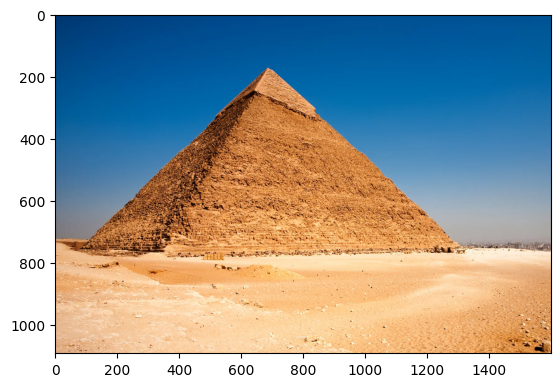

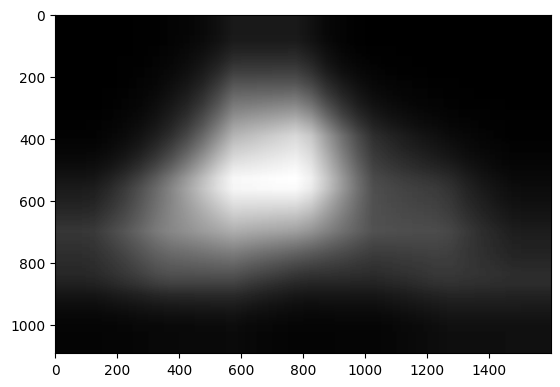

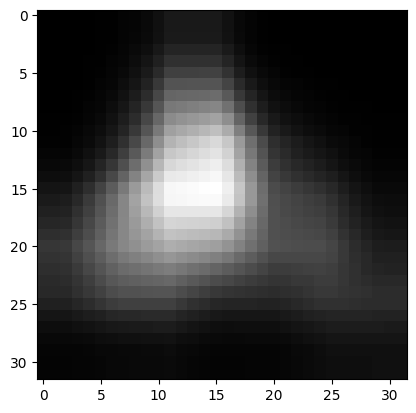

In [28]:
# --- 2. Funcția Principală de Testare (Modificată) ---

if __name__ == "__main__":
    
    # --- MODIFICĂ ACESTE VARIABILE ---
    MODEL_PATH = 'saliency_resnet34.pth'
    CUSTOM_IMAGE_PATH = 'Pyramid-of-Khafre-Giza-Egypt.jpg' # Calea către imaginea ta
    OUTPUT_NAME = 'custom_saliency_prediction.png'
    # ----------------------------------

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Se utilizează dispozitivul: {device}")

    # Vom folosi flag-uri pentru a urmări dacă totul s-a încărcat corect
    model_loaded = False
    image_loaded = False

    # --- 3. Încărcarea Modelului ---
    print(f"Se încarcă modelul din: {MODEL_PATH}")
    model = SaliencyModel()
    
    try:
        model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
        model.to(device)
        model.eval()
        print("Model încărcat cu succes.")
        model_loaded = True # Modelul e gata
        
    except FileNotFoundError:
        print(f"EROARE: Nu am găsit fișierul modelului '{MODEL_PATH}'.")
        print("Asigură-te că ai rulat scriptul de antrenare și ai salvat modelul.")
    except Exception as e:
        print(f"EROARE la încărcarea modelului: {e}")

    # --- 4. Pregătirea Imaginii Custom ---
    
    # Execută acest bloc DOAR dacă modelul s-a încărcat corect
    if model_loaded:
        input_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        print(f"Se încarcă imaginea custom din: {CUSTOM_IMAGE_PATH}")
        try:
            image = Image.open(CUSTOM_IMAGE_PATH).convert('RGB')
            input_tensor = input_transform(image)
            input_tensor = input_tensor.unsqueeze(0) 
            input_tensor = input_tensor.to(device)
            print("Imaginea custom a fost încărcată și procesată.")
            image_loaded = True # Imaginea e gata

        except FileNotFoundError:
            # Aici este modificarea: PRINTEAZĂ eroarea, nu dă exit()
            print(f"EROARE: Nu am găsit imaginea la calea '{CUSTOM_IMAGE_PATH}'.")
            print("Rularea testului s-a oprit.")
        except Exception as e:
            print(f"EROARE la procesarea imaginii: {e}")
            print("Rularea testului s-a oprit.")

    # --- 5. Rularea Predicției (Inferență) ---
    
    # Execută predicția DOAR dacă ȘI modelul ȘI imaginea s-au încărcat
    if model_loaded and image_loaded:
        print("Se rulează predicția...")
        with torch.no_grad():
            prediction_tensor = model(input_tensor) 

        # --- 6. Salvarea Rezultatului ---
        prediction_np = prediction_tensor.squeeze().cpu().numpy()
        output_array = (prediction_np * 255).astype(np.uint8)
        output_image = Image.fromarray(output_array, 'L') 
        output_image.save(OUTPUT_NAME)

        print(f"\n--- SUCCES ---")
        print(f"Harta de saliență a fost salvată ca '{OUTPUT_NAME}'.")

        plt.figure(),plt.imshow(io.imread(CUSTOM_IMAGE_PATH),cmap='gray')

        # upscale salieny map to original image size and show
        output_image_upscaled = output_image.resize(image.size, Image.Resampling.BILINEAR)
        output_image_upscaled.save('predicted_saliency_map_upscaled.png')
        print(f"Harta de saliență redimensionată a fost salvată ca 'predicted_saliency_map_upscaled.png'.")
        plt.figure(),plt.imshow(output_image_upscaled,cmap='gray')
        plt.figure(),plt.imshow(output_image,cmap='gray')
    
    else:
        # Dacă a existat o eroare (model negăsit sau imagine negăsită)
        print("\nTestul nu a fost finalizat din cauza erorilor de mai sus.")